## Pymc

In [1]:
import jax
import jax.numpy as jnp
from jax import lax
import numpy as np
import matplotlib.pyplot as plt

try:
    from tensorflow_probability.substrates import jax as tfp
except ModuleNotFoundError:
    %pip install -qqq tensorflow_probability
    from tensorflow_probability.substrates import jax as tfp

dist = tfp.distributions

try:
    import pymc as pm
except ModuleNotFoundError:
    %pip install -qq pymc
    import pymc as pm

# try:
#     import pymc3 as pm
# except ModuleNotFoundError:
#     %pip install -qq pymc3
#     import pymc3 as pm

try:
    import scipy.stats as stats
except ModuleNotFoundError:
    %pip install -qq scipy
    import scipy.stats as stats

import scipy.special as sp

try:
    import arviz as az
except ModuleNotFoundError:
    %pip install -qq arviz
    import arviz as az

import math

In [2]:
# Use same data as https://github.com/probml/probml-notebooks/blob/main/notebooks/beta_binom_approx_post_pymc.ipynb
key = jax.random.PRNGKey(128)
dataset = np.repeat([0, 1], (10, 1))
n_samples = len(dataset)
print(f"Dataset: {dataset}")
n_heads = dataset.sum()
n_tails = n_samples - n_heads

Dataset: [0 0 0 0 0 0 0 0 0 0 1]


In [3]:
# prior distribution ~ Beta
def prior_dist():
    return dist.Beta(concentration1=1.0, concentration0=1.0)


# likelihood distribution ~ Bernoulli
def likelihood_dist(theta):
    return dist.Bernoulli(probs=theta)

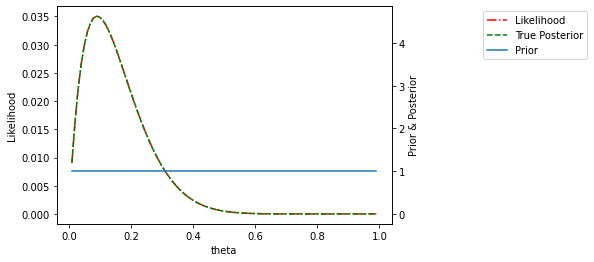

In [4]:
# closed form of beta posterior
a = prior_dist().concentration1
b = prior_dist().concentration0

exact_posterior = dist.Beta(concentration1=a + n_heads, concentration0=b + n_tails)

theta_range = jnp.linspace(0.01, 0.99, 100)

ax = plt.gca()
ax2 = ax.twinx()
(plt2,) = ax2.plot(theta_range, exact_posterior.prob(theta_range), "g--", label="True Posterior")
(plt3,) = ax2.plot(theta_range, prior_dist().prob(theta_range), label="Prior")

likelihood = jax.vmap(lambda x: jnp.prod(likelihood_dist(x).prob(dataset)))(theta_range)
(plt1,) = ax.plot(theta_range, likelihood, "r-.", label="Likelihood")

ax.set_xlabel("theta")
ax.set_ylabel("Likelihood")
ax2.set_ylabel("Prior & Posterior")
ax2.legend(handles=[plt1, plt2, plt3], bbox_to_anchor=(1.6, 1));

In [10]:
# Laplace
with pm.Model() as normal_aproximation:
    theta = pm.Beta("theta", 1.0, 1.0, transform=None)
    y = pm.Binomial("y", n=1, p=theta, observed=dataset)  # Bernoulli
    mean_q = pm.find_MAP()
    std_q = ((1 / pm.find_hessian(mean_q, vars=[theta])) ** 0.5)[0]
    print(pm.find_hessian(mean_q, vars=[theta]))
    loc = mean_q["theta"]
normal_aproximation.compile_d2logp(vars=[theta], jacobian=False)({"theta": 0.66})
# plt.savefig('bb_laplace.pdf');


[[2.18550173]]


array([[88.80087443]])

In [11]:
loc, std_q, mean_q

(array(-1.42857143), array([0.67643243]), {'theta': array(-1.42857143)})

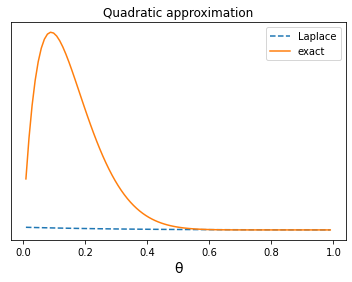

In [12]:
x = theta_range

plt.figure()
plt.plot(x, stats.norm.pdf(x, loc, std_q), "--", label="Laplace")
post_exact = stats.beta.pdf(x, n_heads + 1, n_tails + 1)
plt.plot(x, post_exact, label="exact")
plt.title("Quadratic approximation")
plt.xlabel("θ", fontsize=14)
plt.yticks([])
plt.legend()

Currently this is not giving right answer, see this issue: https://github.com/pymc-devs/pymc/issues/5443